# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [51]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (679 bytes)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pyinstrument_cext-0.2.4-cp310-cp310-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3


In [8]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

role = sagemaker.get_execution_role()
bucket = sagemaker.Session().default_bucket()
print(role)
print("bucket", bucket)

arn:aws:iam::175030374189:role/service-role/AmazonSageMaker-ExecutionRole-20241011T174270
bucket sagemaker-us-east-1-175030374189


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

The Dataset Contains images of dogs which are divided into test, train ad validation dataset where each of the dataset contains 133 different classes.

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2024-10-11 22:28:59--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.113.144, 52.219.194.88, 52.219.192.80, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.113.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  41.1MB/s    in 29s     

2024-10-11 22:29:30 (36.9 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg

In [ ]:
#upload images to s3

s3_path = sagemaker.Session().upload_data(
    path="dogImages",
    bucket=bucket,
    key_prefix="ImageClassification/Dogs"
)

print(f"{s3_path=}")


s3_path='s3://sagemaker-us-east-1-175030374189/ImageClassification/Dogs'


In [12]:
s3_path='s3://sagemaker-us-east-1-175030374189/ImageClassification/Dogs'

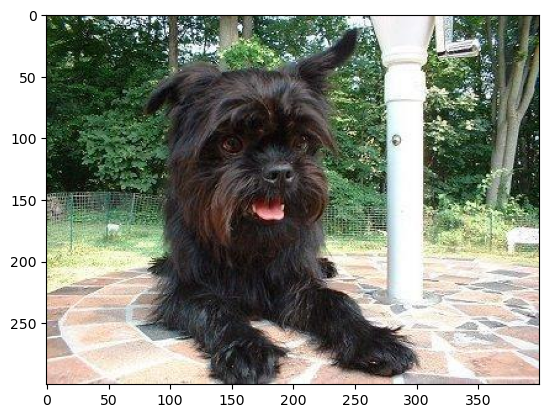

In [13]:
import matplotlib.pyplot as plt
import os
image = plt.imread("dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg")
plt.imshow(image)
plt.show()

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [14]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([16, 32, 64, 128]),
    "epochs": CategoricalParameter([5, 10])
}
objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [15]:
#TODO: Create estimators for your HPs
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version="py36",
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

tuner = HyperparameterTuner(
    estimator = estimator,
    early_stopping_type = "Auto",
    metric_definitions = metric_definitions,
    objective_metric_name = objective_metric_name,
    objective_type = objective_type,
    max_jobs = 4,
    max_parallel_jobs = 2,
    hyperparameter_ranges = hyperparameter_ranges
)

In [16]:
os.environ['SM_CHANNEL_TRAINING']=s3_path
os.environ['SM_MODEL_DIR']=f's3://{bucket}/ImageClassification/Dogs/model'
os.environ['SM_OUTPUT_DATA_DIR']=f's3://{bucket}/ImageClassification/Dogs/output'
tuner.fit({"training": s3_path},wait=True) 

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...........................................................................................................................................................................................................................................................................................................................................!


In [17]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator_hp = best_estimator.hyperparameters()
best_estimator_hp


2024-10-25 20:38:13 Starting - Preparing the instances for training
2024-10-25 20:38:13 Downloading - Downloading the training image
2024-10-25 20:38:13 Training - Training image download completed. Training in progress.
2024-10-25 20:38:13 Uploading - Uploading generated training model
2024-10-25 20:38:13 Completed - Resource reused by training job: pytorch-training-241025-2020-003-a9abf2d0


{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'epochs': '"5"',
 'lr': '0.0010922739232684482',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2024-10-25-20-20-24-120"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-175030374189/pytorch-training-2024-10-25-20-20-24-120/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [20]:
hyperparameters = {"batch_size": int(best_estimator_hp['batch_size'].replace('"', '')),
                   "lr": best_estimator_hp['lr'], "epochs" : int(best_estimator_hp['epochs'].replace('"', ''))}
hyperparameters

{'batch_size': 32, 'lr': '0.0010922739232684482', 'epochs': 5}

In [21]:

from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)
debugger_hook_config=DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "100",
        "eval.save_interval": "10"
    },
    collection_configs=collection_configs
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [22]:


estimator =PyTorch(
    entry_point="train_model.py",
    role=role,
    py_version="py36",
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    #debugging and profiling rules and hooks
    hyperparameters=hyperparameters,
    rules=rules,
    debugger_hook_config=debugger_hook_config,
    profiler_config=profiler_config,
)
estimator.fit({"training": s3_path},wait=True) 

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-10-25-20-49-51-636


2024-10-25 20:49:52 Starting - Starting the training job...
2024-10-25 20:50:19 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2024-10-25 20:50:43 Downloading - Downloading input data......
2024-10-25 20:51:43 Downloading - Downloading the training image........................
2024-10-25 20:55:45 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-10-25 20:55:56,942 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-10-25 20:55:56,976 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-10-25 20:55:56,980 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-10-25 20:55:57,285 sagemaker-training-toolk

In [23]:
# TODO: Plot a debugging output.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
print(job_name)
print(description)

pytorch-training-2024-10-25-20-49-51-636
{'TrainingJobName': 'pytorch-training-2024-10-25-20-49-51-636', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:175030374189:training-job/pytorch-training-2024-10-25-20-49-51-636', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-175030374189/pytorch-training-2024-10-25-20-49-51-636/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '32', 'epochs': '5', 'lr': '"0.0010922739232684482"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-training-2024-10-25-20-49-51-636"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-175030374189/pytorch-training-2024-10-25-20-49-51-636/source/sourcedir.tar.gz"'}, 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.8-gpu-py36', 'TrainingInputMode': 'File', 'EnableSag

In [24]:
pip install protobuf==3.20.

Note: you may need to restart the kernel to use updated packages.


**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [26]:
# TODO: Plot a debugging output.
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
session = boto3.session.Session()
region = session.region_name

training_job = TrainingJob(job_name, region)
training_job.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-175030374189/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-175030374189/pytorch-training-2024-10-25-20-49-51-636/profiler-output


Profiler data from system is available


In [31]:


system_metrics_reader = training_job.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

# view_timeline_charts = TimelineCharts(
#     system_metrics_reader,
#     framework_metrics_reader=None,
#     select_dimensions=["CPU", "GPU"],
#     select_events=["total"],
# )

In [32]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-175030374189/pytorch-training-2024-10-25-20-49-51-636/rule-output


In [33]:
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

2024-10-25 21:06:02     435765 pytorch-training-2024-10-25-20-49-51-636/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-10-25 21:06:01     294481 pytorch-training-2024-10-25-20-49-51-636/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-10-25 21:05:55        559 pytorch-training-2024-10-25-20-49-51-636/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-10-25 21:05:55      15908 pytorch-training-2024-10-25-20-49-51-636/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-10-25 21:05:55       1748 pytorch-training-2024-10-25-20-49-51-636/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-10-25 21:05:55        327 pytorch-training-2024-10-25-20-49-51-636/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2024-10-25 21:05:55       1502 pytorch-training-2024-10-25-20-49-51-636/rule-output/ProfilerReport/profiler-output/profiler-re

In [34]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [35]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [118]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
role = sagemaker.get_execution_role()
model_data = "s3://sagemaker-us-east-1-175030374189/pytorch-training-2024-10-25-20-49-51-636/output/model.tar.gz"


In [119]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [120]:
pytorch_model = PyTorchModel(model_data=model_data, role=role, entry_point='Inference.py',py_version='py3',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

In [121]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

-------!

In [122]:
!pip install torchvision -q

In [123]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as trans

In [124]:
# TODO: Run an prediction on the endpoint

image_path = "./dogImages/test/014.Basenji/Basenji_00955.jpg"
# TODO: Run an prediction on the endpoint
with open(image_path, "rb") as f:
    payload = f.read()
    
type(payload)



bytes

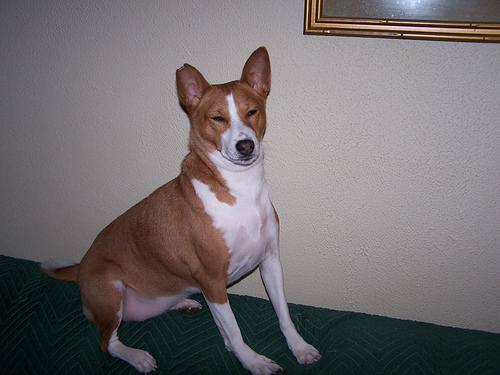

In [125]:
import io
Image.open(io.BytesIO(payload))

In [126]:

response=predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
response

[[-12.225271224975586,
  -12.060521125793457,
  -7.332470893859863,
  -3.8586180210113525,
  -11.298728942871094,
  -5.904918670654297,
  -1.1049692630767822,
  -2.5405776500701904,
  -12.67615795135498,
  -8.683405876159668,
  -5.083083629608154,
  -10.817243576049805,
  -10.431400299072266,
  4.617236614227295,
  -10.896927833557129,
  -6.170953273773193,
  -13.210261344909668,
  -8.164113998413086,
  -3.9818267822265625,
  -6.4269185066223145,
  -6.898367404937744,
  -13.085464477539062,
  -17.250600814819336,
  -9.89629077911377,
  -14.887106895446777,
  -15.521074295043945,
  -14.357877731323242,
  -12.138896942138672,
  -8.954717636108398,
  -10.093539237976074,
  -4.626553535461426,
  -4.395002365112305,
  -15.141561508178711,
  -7.1021318435668945,
  -9.214286804199219,
  -13.403470993041992,
  -8.421446800231934,
  -7.947689533233643,
  1.6021170616149902,
  -9.300614356994629,
  -12.109010696411133,
  -6.734778881072998,
  2.5490434169769287,
  -12.256806373596191,
  -2.27845

In [127]:
pred = np.argmax(response, 1) + 1

actual = int(image_path.split('.')[1].split('/')[-1])
print(f"Actual: {actual}, Prediction: {pred[0]}")

Actual: 14, Prediction: 14


Actual: 14, Prediction: 7


In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

In [128]:
!jupyter nbconvert --to html train_and_deploy.ipynb

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook train_and_deploy.ipynb to html
[NbConvertApp] Writing 2761697 bytes to train_and_deploy.html
